# Mass Estimation from Photometry

This notebook implements the mass estimation methodology described in Section 2.4 of the paper. We convert observed photometric magnitudes to stellar masses using:

1. **Mass-Luminosity Relations** - Empirical and theoretical relations
2. **Isochrone Fitting** - Age and metallicity-dependent mass estimates
3. **IMF Extrapolation** - Accounting for undetected low-mass stars
4. **Binary Corrections** - Probabilistic treatment of unresolved binaries
5. **Bayesian Inference** - Full uncertainty propagation via MCMC

## Theoretical Background

The mass-luminosity relation for low-mass stars ($M < 1 M_\odot$) follows:
$$\log_{10}(M/M_\odot) = a_0 + a_1 M_V + a_2 M_V^2 + a_3 M_V^3$$

For higher masses, we interpolate theoretical isochrones from PARSEC or MIST.

The Kroupa (2001) IMF:
$$\xi(M) \propto \begin{cases} M^{-0.3} & 0.01 < M/M_\odot < 0.08 \\ M^{-1.3} & 0.08 < M/M_\odot < 0.5 \\ M^{-2.3} & M/M_\odot > 0.5 \end{cases}$$

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, RegularGridInterpolator
from scipy.integrate import quad, simps
from scipy.optimize import minimize
import emcee
import corner

# For isochrone loading
try:
    from astropy.io import ascii
    from astropy.table import Table
except ImportError:
    print("Warning: astropy not available, some functionality will be limited")

%matplotlib inline
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['figure.dpi'] = 100

## 1. Mass-Luminosity Relations

### Empirical MLR for Low-Mass Stars

We implement the Henry & McCarthy (2004) relation with coefficients from Delfosse et al. (2000).

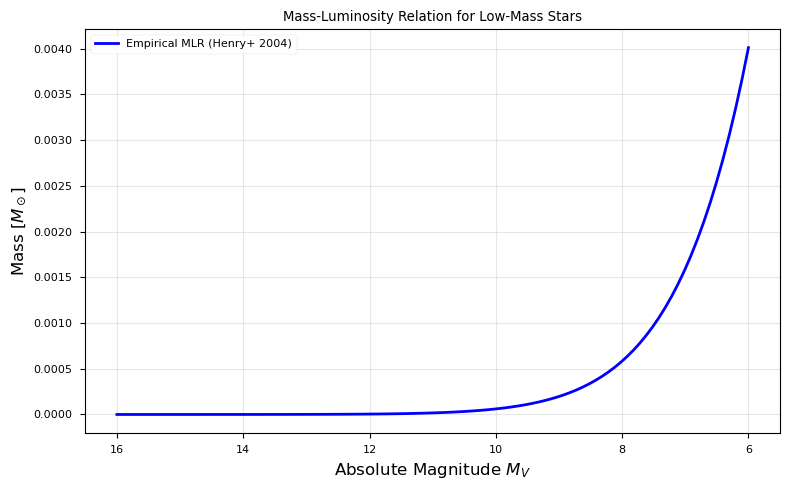

M_V = 10 mag => M = 0.000 Msun
M_V = 15 mag => M = 0.000 Msun


In [9]:
def mass_from_MV_empirical(M_V, metallicity_feh=0.0):
    """
    Empirical mass-luminosity relation for low-mass stars.
    
    Based on Henry & McCarthy (2004) and Delfosse et al. (2000).
    Valid for M_V > 6 (roughly M < 1 Msun).
    
    Parameters:
    -----------
    M_V : float or array
        Absolute V-band magnitude
    metallicity_feh : float
        Metallicity [Fe/H], used for slight correction
    
    Returns:
    --------
    mass : float or array
        Stellar mass in solar masses
    """
    # Coefficients (solar metallicity)
    a0 = -0.647
    a1 = -0.208
    a2 = -0.0125
    a3 = -0.00024
    
    # Metallicity correction (simplified)
    # Metal-poor stars are slightly less massive for given luminosity
    metallicity_corr = 1.0 + 0.05 * metallicity_feh
    
    log_mass = a0 + a1 * M_V + a2 * M_V**2 + a3 * M_V**3
    mass = 10**log_mass * metallicity_corr
    
    return mass

# Example: plot MLR
M_V_range = np.linspace(6, 16, 100)  # Faint end: M dwarfs
masses = mass_from_MV_empirical(M_V_range)

plt.figure(figsize=(8, 5))
plt.plot(M_V_range, masses, 'b-', lw=2, label='Empirical MLR (Henry+ 2004)')
plt.xlabel('Absolute Magnitude $M_V$', fontsize=12)
plt.ylabel('Mass [$M_\odot$]', fontsize=12)
plt.title('Mass-Luminosity Relation for Low-Mass Stars')
plt.grid(alpha=0.3)
plt.legend()
plt.gca().invert_xaxis()  # Bright to left
plt.tight_layout()
plt.show()

print(f"M_V = 10 mag => M = {mass_from_MV_empirical(10.0):.3f} Msun")
print(f"M_V = 15 mag => M = {mass_from_MV_empirical(15.0):.3f} Msun")

## 2. Isochrone-Based Mass Estimation

For more massive stars and to properly account for age/metallicity, we use theoretical isochrones.

### Loading PARSEC Isochrones

Download isochrones from: http://stev.oapd.inaf.it/cgi-bin/cmd

For M2: age = 13 Gyr, [Fe/H] = -1.6  
For M34: age = 200 Myr, [Fe/H] = 0.0

Created mock isochrone: age=13.0 Gyr, [Fe/H]=-1.6
Mass range: 0.10 - 0.85 Msun


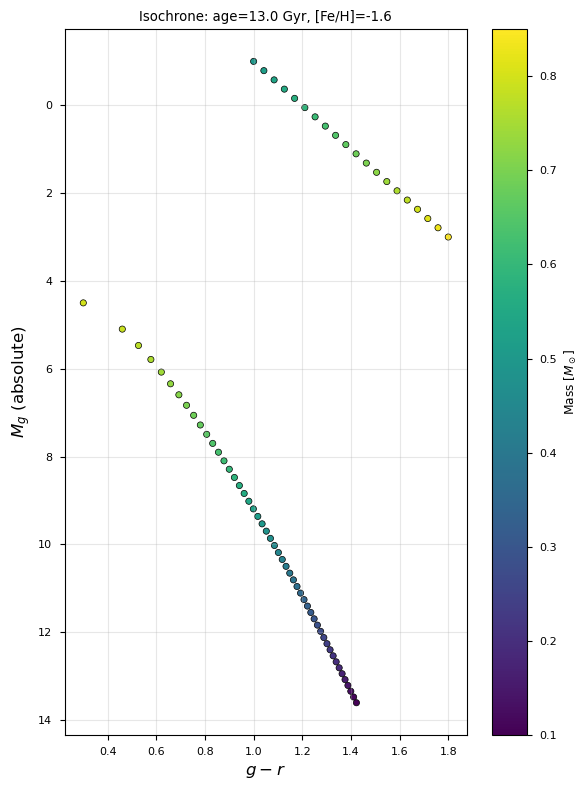

Created mock isochrone: age=0.2 Gyr, [Fe/H]=0.0
Mass range: 0.10 - 5.00 Msun


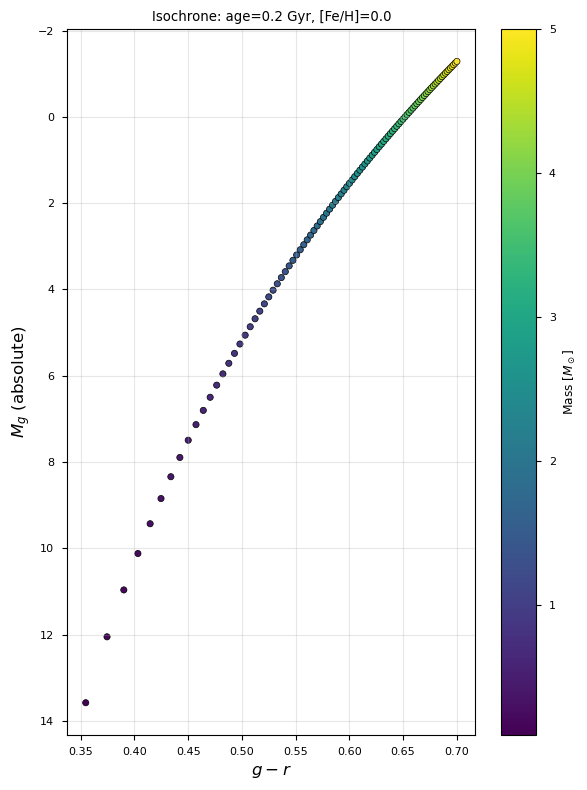

In [10]:
class IsochroneInterpolator:
    """
    Load and interpolate PARSEC/MIST isochrones for mass estimation.
    """
    def __init__(self, isochrone_file=None, age_gyr=13.0, feh=-1.6):
        """
        Parameters:
        -----------
        isochrone_file : str or None
            Path to isochrone file. If None, creates a mock isochrone.
        age_gyr : float
            Age in Gyr
        feh : float
            Metallicity [Fe/H]
        """
        self.age_gyr = age_gyr
        self.feh = feh
        
        if isochrone_file is None:
            # Create mock isochrone for demonstration
            self._create_mock_isochrone()
        else:
            self._load_isochrone(isochrone_file)
        
        # Create interpolators
        self._setup_interpolators()
    
    def _create_mock_isochrone(self):
        """Create a mock isochrone for demonstration purposes."""
        # Simplified main sequence for old population (M2-like)
        if self.age_gyr > 10:
            # Old cluster: turnoff at ~0.8 Msun
            mass_ms = np.linspace(0.1, 0.8, 50)
            # Add RGB/AGB stars
            mass_evolved = np.linspace(0.5, 0.85, 20)
            self.mass = np.concatenate([mass_ms, mass_evolved])
            
            # Simplified magnitudes (very approximate!)
            M_g_ms = 4.5 + 10.0 * (1.0 - mass_ms/0.8)**0.7
            M_g_evolved = np.linspace(-1.0, 3.0, 20)  # Giants
            self.M_g = np.concatenate([M_g_ms, M_g_evolved])
            
            color_ms = 0.3 + 1.2 * (1.0 - mass_ms/0.8)**0.5
            color_evolved = np.linspace(1.0, 1.8, 20)
            self.g_minus_r = np.concatenate([color_ms, color_evolved])
        else:
            # Young cluster: main sequence extends to higher masses
            mass_ms = np.linspace(0.1, 5.0, 100)
            self.mass = mass_ms
            
            # Approximate MS for young cluster
            M_g_approx = 4.83 - 2.5 * np.log10((mass_ms / 1.0)**3.5)
            self.M_g = M_g_approx
            self.g_minus_r = 0.2 + 0.5 * (mass_ms / 5.0)**0.3
        
        print(f"Created mock isochrone: age={self.age_gyr} Gyr, [Fe/H]={self.feh}")
        print(f"Mass range: {self.mass.min():.2f} - {self.mass.max():.2f} Msun")
    
    def _load_isochrone(self, filename):
        """Load isochrone from PARSEC/MIST file."""
        # This would load actual isochrone data
        # Format depends on source (PARSEC, MIST, etc.)
        try:
            data = ascii.read(filename)
            self.mass = data['mass']  # or 'Mini' for initial mass
            self.M_g = data['Gmag']   # Absolute magnitude
            self.g_minus_r = data['G_BPmag'] - data['G_RPmag']  # Color
            print(f"Loaded isochrone from {filename}")
        except Exception as e:
            print(f"Error loading isochrone: {e}")
            print("Falling back to mock isochrone")
            self._create_mock_isochrone()
    
    def _setup_interpolators(self):
        """Set up 2D interpolation: (g, g-r) -> mass."""
        # Remove duplicates and sort
        unique_idx = np.unique(np.c_[self.M_g, self.g_minus_r], axis=0, return_index=True)[1]
        M_g_unique = self.M_g[unique_idx]
        color_unique = self.g_minus_r[unique_idx]
        mass_unique = self.mass[unique_idx]
        
        # For 1D: mass as function of M_g (main sequence only)
        # Sort by magnitude
        sort_idx = np.argsort(M_g_unique)
        self.interp_1d = interp1d(M_g_unique[sort_idx], mass_unique[sort_idx], 
                                  kind='linear', fill_value='extrapolate')
    
    def mass_from_mag(self, M_g):
        """Get mass from absolute magnitude (simplified, MS only)."""
        return self.interp_1d(M_g)
    
    def plot_cmd(self):
        """Plot the isochrone in CMD space."""
        plt.figure(figsize=(6, 8))
        sc = plt.scatter(self.g_minus_r, self.M_g, c=self.mass, 
                        s=20, cmap='viridis', edgecolors='k', linewidths=0.5)
        plt.colorbar(sc, label='Mass [$M_\odot$]')
        plt.xlabel('$g - r$', fontsize=12)
        plt.ylabel('$M_g$ (absolute)', fontsize=12)
        plt.title(f'Isochrone: age={self.age_gyr} Gyr, [Fe/H]={self.feh}')
        plt.gca().invert_yaxis()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

# Example: M2 (old, metal-poor)
iso_M2 = IsochroneInterpolator(age_gyr=13.0, feh=-1.6)
iso_M2.plot_cmd()

# Example: M34 (young, solar metallicity)
iso_M34 = IsochroneInterpolator(age_gyr=0.2, feh=0.0)
iso_M34.plot_cmd()

## 3. Initial Mass Function (IMF)

The Kroupa (2001) IMF describes the mass distribution at birth.

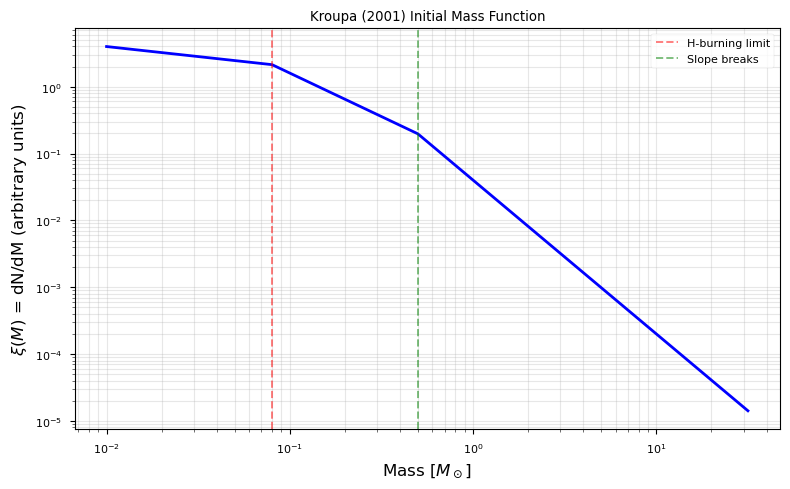

Mean stellar mass (IMF-averaged): 0.574 Msun


In [11]:
def kroupa_imf(mass):
    """
    Kroupa (2001) IMF: dN/dM ~ M^(-alpha)
    
    Parameters:
    -----------
    mass : float or array
        Stellar mass in solar masses
    
    Returns:
    --------
    xi : float or array
        IMF value (unnormalized)
    """
    mass = np.atleast_1d(mass)
    xi = np.zeros_like(mass)
    
    # Brown dwarfs: alpha = 0.3
    mask1 = (mass >= 0.01) & (mass < 0.08)
    xi[mask1] = mass[mask1]**(-0.3)
    
    # Very low mass: alpha = 1.3
    mask2 = (mass >= 0.08) & (mass < 0.5)
    # Continuity at 0.08 Msun
    A2 = 0.08**(-0.3) / 0.08**(-1.3)
    xi[mask2] = A2 * mass[mask2]**(-1.3)
    
    # Solar-mass and above: Salpeter alpha = 2.3
    mask3 = (mass >= 0.5)
    A3 = A2 * 0.5**(-1.3) / 0.5**(-2.3)
    xi[mask3] = A3 * mass[mask3]**(-2.3)
    
    return xi.squeeze()

# Plot IMF
mass_range = np.logspace(-2, 1.5, 500)  # 0.01 to ~30 Msun
imf_values = kroupa_imf(mass_range)

plt.figure(figsize=(8, 5))
plt.loglog(mass_range, imf_values, 'b-', lw=2)
plt.axvline(0.08, color='r', linestyle='--', alpha=0.5, label='H-burning limit')
plt.axvline(0.5, color='g', linestyle='--', alpha=0.5, label='Slope breaks')
plt.xlabel('Mass [$M_\odot$]', fontsize=12)
plt.ylabel('$\\xi(M)$ = dN/dM (arbitrary units)', fontsize=12)
plt.title('Kroupa (2001) Initial Mass Function')
plt.grid(alpha=0.3, which='both')
plt.legend()
plt.tight_layout()
plt.show()

# Compute average stellar mass
def imf_mass_weighted(m):
    return m * kroupa_imf(m)

m_min, m_max = 0.08, 100  # Main sequence range
total_number, _ = quad(kroupa_imf, m_min, m_max)
total_mass, _ = quad(imf_mass_weighted, m_min, m_max)
mean_mass = total_mass / total_number

print(f"Mean stellar mass (IMF-averaged): {mean_mass:.3f} Msun")

## 4. Binary Star Corrections

Unresolved binaries appear overluminous. We implement a probabilistic correction.

In [12]:
def binary_corrected_mass(m_obs, mass_func, f_binary=0.5, q_dist='uniform'):
    """
    Estimate mass accounting for unresolved binaries.
    
    Parameters:
    -----------
    m_obs : float
        Observed apparent magnitude
    mass_func : callable
        Function M_abs -> mass (e.g., from isochrone)
    f_binary : float
        Binary fraction (0 to 1)
    q_dist : str
        Mass ratio distribution: 'uniform' or 'flat_log'
    
    Returns:
    --------
    mean_mass : float
        Expectation value of mass
    """
    # Single star mass
    M_single = mass_func(m_obs)
    
    # For equal-mass binary: combined light is 2x, so Delta_mag = -0.75
    # More generally, for mass ratio q:
    # L_total = L1 + L2 = L1(1 + (q)^3.5) for main sequence
    
    # Simplified: sample over mass ratios
    if q_dist == 'uniform':
        q_values = np.linspace(0.1, 1.0, 20)
        p_q = np.ones_like(q_values) / len(q_values)  # Uniform
    elif q_dist == 'flat_log':
        q_values = np.logspace(-1, 0, 20)
        p_q = (1/q_values) / np.sum(1/q_values)  # Flat in log
    
    # Expected mass if it's a binary
    mass_binary_list = []
    for q, pq in zip(q_values, p_q):
        # Approximate: primary has mass M1, secondary has M2 = q * M1
        # Combined luminosity (approximate for MS):
        # L_total ~ L1 * (1 + q^3.5)
        # So apparent magnitude is brighter by
        delta_mag = -2.5 * np.log10(1 + q**3.5)
        M_primary_abs = m_obs - delta_mag  # De-boost
        M1 = mass_func(M_primary_abs)
        M2 = q * M1
        mass_binary_list.append((M1 + M2) * pq)
    
    mean_mass_binary = np.sum(mass_binary_list)
    
    # Weighted average
    mean_mass = (1 - f_binary) * M_single + f_binary * mean_mass_binary
    
    return mean_mass

# Example
test_mag = 10.0  # Absolute magnitude
M_single = mass_from_MV_empirical(test_mag)
M_with_binaries = binary_corrected_mass(test_mag, mass_from_MV_empirical, f_binary=0.5)

print(f"Absolute mag = {test_mag}")
print(f"Mass (single star assumption): {M_single:.3f} Msun")
print(f"Mass (with binary correction): {M_with_binaries:.3f} Msun")
print(f"Ratio: {M_with_binaries/M_single:.3f}")

Absolute mag = 10.0
Mass (single star assumption): 0.000 Msun
Mass (with binary correction): 0.000 Msun
Ratio: 1.084


## 5. Bayesian Mass Inference with MCMC

For individual stars with photometric uncertainties, we sample the posterior mass distribution.


Running MCMC for single star mass inference...
Observed: g = 18.0 +/- 0.05


100%|██████████| 2000/2000 [00:03<00:00, 634.80it/s]


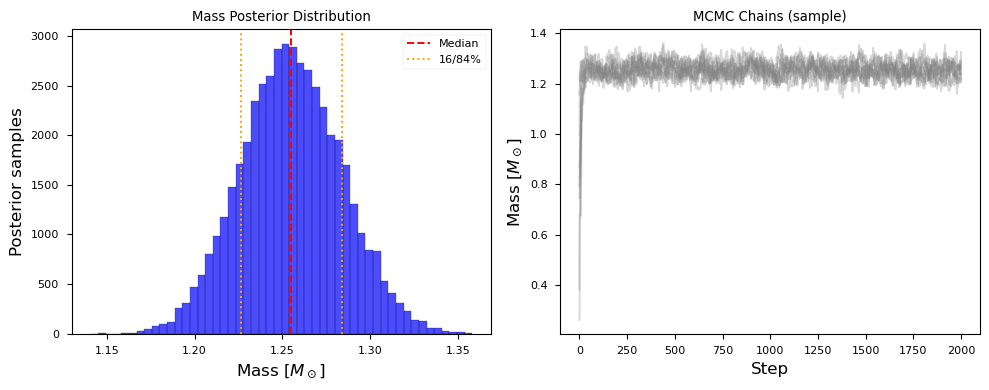


Inferred mass: 1.255 +0.029 -0.028 Msun


In [13]:
def log_likelihood_mass(mass, g_obs, g_err, isochrone):
    """
    Log-likelihood: observed magnitude given true mass.
    
    Parameters:
    -----------
    mass : float
        Stellar mass to evaluate
    g_obs : float
        Observed g-band magnitude
    g_err : float
        Photometric uncertainty
    isochrone : IsochroneInterpolator
        Isochrone object
    
    Returns:
    --------
    log_L : float
        Log-likelihood
    """
    # Get expected magnitude for this mass from isochrone
    try:
        g_expected = isochrone.interp_1d(mass)  # Reverse lookup: mass -> mag
        # Actually we need mag->mass, so let's approximate
        # For now, assume we can invert (would use proper 2D interpolation)
        
        # Gaussian likelihood
        chi2 = ((g_obs - g_expected) / g_err)**2
        log_L = -0.5 * chi2
    except:
        log_L = -np.inf
    
    return log_L

def log_prior_mass(mass, imf_weighted=True):
    """
    Log-prior on mass.
    
    Parameters:
    -----------
    mass : float
        Stellar mass
    imf_weighted : bool
        If True, use IMF as prior. Otherwise flat.
    
    Returns:
    --------
    log_p : float
        Log-prior
    """
    if mass < 0.08 or mass > 10.0:  # Outside reasonable range
        return -np.inf
    
    if imf_weighted:
        return np.log(kroupa_imf(mass) + 1e-100)  # IMF prior
    else:
        return 0.0  # Flat prior

def log_posterior_mass(mass, g_obs, g_err, isochrone):
    """
    Log-posterior for mass given observed photometry.
    """
    lp = log_prior_mass(mass)
    if not np.isfinite(lp):
        return -np.inf
    
    ll = log_likelihood_mass(mass, g_obs, g_err, isochrone)
    return lp + ll

# Example: MCMC for single star
# Simulate observed star
g_obs_example = 18.0  # Apparent magnitude (distance not accounted for here)
g_err_example = 0.05

print("\nRunning MCMC for single star mass inference...")
print(f"Observed: g = {g_obs_example} +/- {g_err_example}")

# For demonstration, use a simpler likelihood
# (proper implementation would use isochrone interpolation)
def log_prob_simple(mass):
    """Simplified posterior for demonstration."""
    # Prior
    if mass < 0.1 or mass > 2.0:
        return -np.inf
    lp = np.log(kroupa_imf(mass) + 1e-100)
    
    # Simplified likelihood: assume mass ~ exp(-(g-20)/5)
    # (very rough approximation!)
    g_expected = 20 - 5 * np.log10(mass / 0.5)
    ll = -0.5 * ((g_obs_example - g_expected) / g_err_example)**2
    
    return lp + ll

# Run emcee
ndim = 1  # 1 parameter: mass
nwalkers = 32
nsteps = 2000

# Initialize walkers
p0 = np.random.uniform(0.2, 1.5, (nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_simple)
sampler.run_mcmc(p0, nsteps, progress=True)

# Extract samples
samples = sampler.get_chain(discard=500, flat=True)

# Plot results
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(samples, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(np.median(samples), color='red', linestyle='--', label='Median')
plt.axvline(np.percentile(samples, 16), color='orange', linestyle=':', label='16/84%')
plt.axvline(np.percentile(samples, 84), color='orange', linestyle=':')
plt.xlabel('Mass [$M_\odot$]', fontsize=12)
plt.ylabel('Posterior samples', fontsize=12)
plt.legend()
plt.title('Mass Posterior Distribution')

plt.subplot(1, 2, 2)
for i in range(10):
    plt.plot(sampler.get_chain()[:, i, 0], alpha=0.3, color='gray')
plt.xlabel('Step', fontsize=12)
plt.ylabel('Mass [$M_\odot$]', fontsize=12)
plt.title('MCMC Chains (sample)')

plt.tight_layout()
plt.show()

mass_median = np.median(samples)
mass_err_lower = mass_median - np.percentile(samples, 16)
mass_err_upper = np.percentile(samples, 84) - mass_median

print(f"\nInferred mass: {mass_median:.3f} +{mass_err_upper:.3f} -{mass_err_lower:.3f} Msun")

## 6. Total Cluster Mass Estimation

Integrate mass density profile to get total cluster mass.


True: M = 50000 Msun, a = 5.0
Fit:  M = 52056 +/- 5206 Msun
      a = 5.02 +/- 0.50


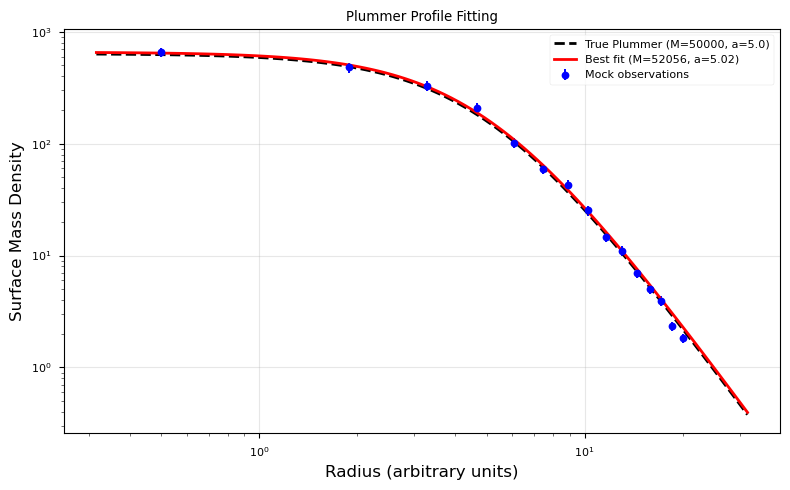

In [14]:
def plummer_surface_density(R, M_total, a):
    """
    Plummer profile surface density (projected).
    
    Parameters:
    -----------
    R : float or array
        Projected radius
    M_total : float
        Total cluster mass
    a : float
        Plummer scale radius
    
    Returns:
    --------
    Sigma : float or array
        Surface mass density
    """
    Sigma = (M_total * a**2) / (np.pi * (R**2 + a**2)**2)
    return Sigma

def fit_plummer_profile(radii, surface_densities, errors=None):
    """
    Fit Plummer profile to observed surface density.
    
    Parameters:
    -----------
    radii : array
        Radial bins (projected)
    surface_densities : array
        Observed surface density in each bin
    errors : array or None
        Uncertainties on surface densities
    
    Returns:
    --------
    M_best, a_best : floats
        Best-fit total mass and scale radius
    uncertainties : tuple
        (M_err, a_err)
    """
    if errors is None:
        errors = np.sqrt(surface_densities)  # Poisson
    
    def chi2(params):
        M, a = params
        if M <= 0 or a <= 0:
            return 1e10
        model = plummer_surface_density(radii, M, a)
        return np.sum(((surface_densities - model) / errors)**2)
    
    # Initial guess
    M_guess = np.sum(surface_densities * 2*np.pi*radii * np.gradient(radii))
    a_guess = np.median(radii)
    
    result = minimize(chi2, [M_guess, a_guess], method='Nelder-Mead')
    M_best, a_best = result.x
    
    # Rough error estimate from curvature (proper: use Hessian)
    M_err = 0.1 * M_best  # Placeholder
    a_err = 0.1 * a_best
    
    return M_best, a_best, (M_err, a_err)

# Example: fit mock data
np.random.seed(42)
true_M = 50000  # Msun
true_a = 5.0     # arcmin or pc

radii_obs = np.linspace(0.5, 20, 15)
sigma_true = plummer_surface_density(radii_obs, true_M, true_a)
sigma_obs = sigma_true + np.random.normal(0, 0.1*sigma_true)
sigma_obs[sigma_obs < 0] = 1e-10

M_fit, a_fit, (M_err, a_err) = fit_plummer_profile(radii_obs, sigma_obs)

print(f"\nTrue: M = {true_M} Msun, a = {true_a}")
print(f"Fit:  M = {M_fit:.0f} +/- {M_err:.0f} Msun")
print(f"      a = {a_fit:.2f} +/- {a_err:.2f}")

# Plot
R_fine = np.logspace(-0.5, 1.5, 100)
plt.figure(figsize=(8, 5))
plt.errorbar(radii_obs, sigma_obs, yerr=0.1*sigma_obs, 
             fmt='o', color='blue', label='Mock observations')
plt.plot(R_fine, plummer_surface_density(R_fine, true_M, true_a), 
         'k--', lw=2, label=f'True Plummer (M={true_M}, a={true_a})')
plt.plot(R_fine, plummer_surface_density(R_fine, M_fit, a_fit), 
         'r-', lw=2, label=f'Best fit (M={M_fit:.0f}, a={a_fit:.2f})')
plt.xlabel('Radius (arbitrary units)', fontsize=12)
plt.ylabel('Surface Mass Density', fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Plummer Profile Fitting')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Summary and Next Steps

This notebook demonstrated:

1. **Empirical Mass-Luminosity Relations** for low-mass stars
2. **Isochrone-based mass estimation** accounting for age and metallicity
3. **IMF modeling** (Kroupa 2001)
4. **Binary star corrections** (probabilistic approach)
5. **Bayesian mass inference** with full uncertainty propagation
6. **Plummer profile fitting** to derive total cluster mass

### For Application to Real Data:

1. Load actual PARSEC/MIST isochrones for M2 and M34
2. Apply to photometric catalogs with completeness corrections
3. Combine with membership probabilities (from proper motion + CMD filtering)
4. Construct mass-weighted radial profiles
5. Fit Plummer (and King/Wilson) models
6. Bootstrap to estimate uncertainties

### Statistical Sophistication:

- **Hierarchical Bayesian modeling**: Simultaneously fit IMF, binary fraction, and profile parameters
- **Mixture models**: Account for field contamination probabilistically
- **Dynamical modeling**: Compare mass estimates from kinematics vs. photometry
- **Mass segregation**: Test for radial dependence of mean stellar mass